In [3]:
# Module Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
%matplotlib inline

# Print Controll Setting
import warnings
warnings.simplefilter(action='ignore')
pd.options.display.max_columns = None

# Visualization Setting
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_palette('rocket', n_colors=10)
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

In [4]:
df = pd.read_csv('data/2023빅콘테스트_어드밴스드리그_예술의전당.csv')
df_concert = df[df['place']=='콘서트홀']; df.head()

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn
0,50.0,F,골드,무료,그린,NaN,NaN,NaN,20220114,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,20220114.0,20220115.0,교향곡,콘서트홀,120,15,Y
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211003,1550,20211009,2000,1층 7열 5,0,0,초대권,1120,NaN,20210823.0,독주,리사이틀홀,90,15,N
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220917,1520,20221105,2000,1층 C블록 16열 3,0,0,초대권,2283,20220911.0,20220911.0,독주,IBK챔버홀,80,15,N
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20190630,1132,20190731,2000,1층 2열 3,0,0,초대권,2798,NaN,20190701.0,독주,리사이틀홀,90,15,N
4,50.0,M,무료,NaN,NaN,NaN,NaN,NaN,20220206,1615,20220302,1930,1층 B블록12열 7,180000,0,일반,897,20220109.0,20220110.0,독주,콘서트홀,90,0,Y


# Data Preprocessing

In [5]:
# 비회원인데 멤버십이 있는 행 제거
fidx = df_concert[df_concert['member_yn']=='N'][df_concert['membership_type_1'].notna()].index
df_concert = df_concert.drop(index = fidx).reset_index().iloc[:,1:]

In [6]:
# 실제 공연 내역과 비교했을 때 없는 공연 → 결측치로 판단, 제거
nidx = df_concert.loc[df_concert['performance_code']==852].index
df_concert = df_concert.drop(index = nidx).reset_index().iloc[:,1:]

In [7]:
# genre가 NaN인 공연의 play_date와 place를 기반으로 예술의전당 홈페이지를 통해 결측치 대체
mapping = {229:'교향곡', 2818:'클래식', 352:'교향곡', 1221:'콘서트', 2816:'클래식', 2819:'클래식', 988:'클래식',
           2215:'클래식', 47:'클래식', 588:'교향곡', 1405:'기타', 2937:'클래식', 354:'클래식', 2472:'콘서트', 1751:'클래식'}

for c, g in mapping.items():
    df_concert.loc[df_concert['performance_code'] == c, 'genre'] = g

In [8]:
# 선예매일과 예매일 둘 다 없는 경우 삭제
df_concert = df_concert.dropna(subset=['pre_open_date', 'open_date'], how='all')

In [9]:
# 공연수와 데이터가 매우 적은 장르의 데이터 삭제
df_concert = df_concert[~df_concert.genre.isin(['복합장르','기타','재즈','크로스오버'])]

In [10]:
# column 전체가 NaN값인 membership_type_6 행 제거 (홈페이지 정보에 따르면 한 사람이 6개의 멤버십을 가질 수 없다고 판단함)
df_concert = df_concert.drop('membership_type_6', axis=1)

In [13]:
# 날짜의 값을 가지는 tran_date, play_date, open_date, pre_open_date
df_concert['tran_date'] = pd.to_datetime(df_concert['tran_date'], format='%Y%m%d')
df_concert['play_date'] = pd.to_datetime(df_concert['play_date'], format='%Y%m%d')
df_concert['open_date'] = pd.to_datetime(df_concert['open_date'], format='%Y%m%d')
df_concert['pre_open_date'] = pd.to_datetime(df_concert['pre_open_date'], format='%Y%m%d')

In [14]:
# seat열에서 단어간 띄어쓰기 반영
df_concert['seat'] = df_concert['seat'].apply(lambda x: re.sub(r'(?<=[층블록열])(?=[A-N0-9])', ' ', x))

In [15]:
# member_yn열에서 Y는 1, N은 0
df_concert['member_yn'] = df_concert['member_yn'].apply(lambda x: 1 if x == 'Y' else 0)

In [16]:
# pre_open_date가 NaN값인 경우 open_date로 대체
df_concert['pre_open_date'] = df_concert['pre_open_date'].fillna(df_concert['open_date'])

In [17]:
# 콘서트홀에 존재하지 않는 좌석 이상치로 판단, 삭제
df_concert = df_concert[~df_concert['seat'].isin(['2층 A블록 8열 12','2층 A블록 8열 13','2층 E블록 8열 12', '2층 E블록 8열 13'])]

In [18]:
# 예매 여부
df_concert['reservation_yn'] = df_concert['ticket_cancel'].apply(lambda x : 1 if x == 0 else 0)

In [19]:
# 공연-공연날짜 unique 값 생성 (2일 이상 지속된 공연에 대해 공연 날짜에 따라 별개로 취급해줌)
df_concert['unique_perform_code'] = df_concert.groupby(['performance_code', 'play_date', 'play_st_time']).ngroup()

In [20]:
# 최종 예매 데이터 - 공연별 좌석에 중복 예매 내역, 취소 내역에 대해서 가장 최신의 내역만 사용
df_concert = df_concert.sort_values(by=['unique_perform_code', 'seat', 'tran_date', 'tran_time', 'reservation_yn'], ascending=[True, True, False, False, False])
df_concert = df_concert.groupby(['unique_perform_code', 'seat']).first().reset_index()

***
# Feature Extraction

In [21]:
# 데이터 기간동안의 공휴일 list 생성 후 자료형을 pandas의 datetime으로 변환
lst_str_holiday = ['20181225','20190101','20190204','20190205','20190206','20190301','20190505','20190506','20190606','20190815',
                   '20190912','20190913','20190914','20191003','20191009','20191225','20200101','20200124','20200125','20200126',
                   '20200127','20200301','20200415','20200430','20200505','20200606','20200815','20200817','20201001','20201002',
                   '20201003','20201009','20201225','20210101','20210211','20210212','20210213','20210301','20210505','20210519',
                   '20210606','20210815','20210816','20210920','20210921','20210922','20211003','20211004','20211009','20211011',
                   '20211225','20220101','20220131','20220201','20220202','20220301','20220309','20220505','20220508','20220601',
                   '20220606','20220815','20220909','20220910','20220911','20220912','20221003','20221009','20221010','20221225',
                   '20230101','20230221','20230222','20230223','20230224','20230301','20230505','20230527','20230529','20230606']

lst_holiday = pd.to_datetime(lst_str_holiday)

In [22]:
# play_date가 공휴일이면 1, 아니면 0
df_concert['play_holiday'] = df_concert['play_date'].apply(lambda x : 1 if x in lst_holiday else 0)

# play_date 요일
df_concert['play_weekday'] = df_concert['play_date'].apply(lambda x : x.weekday())

# play_date 년도
df_concert['play_year'] = df_concert['play_date'].apply(lambda x : x.year)

# play_date 월
df_concert['play_month'] = df_concert['play_date'].apply(lambda x : x.month)

In [23]:
# tran_date과 pre_open_date의 차이
df_concert['tran_diff_pre_open'] = (df_concert['tran_date'] - df_concert['pre_open_date']).dt.days.apply(lambda x : 0 if x < 0 else x)

In [24]:
# seat열에서 층, 박스/블록, 열, 번호를 분리해서 새로운 열 생성
df_concert['seat_floor'] = df_concert['seat'].str.extract(r'(\d)층').fillna('합창석')
df_concert['seat_box'] = df_concert['seat'].str.extract(r'BOX(\d{1,2})')
df_concert['seat_block'] = df_concert['seat'].str.extract(r' ([A-N])블록')[0].combine_first(df_concert['seat_box'])
df_concert['seat_row'] = df_concert['seat'].str.extract(r' (\d{1,2})열').fillna(0).astype(int)
df_concert['seat_num'] = df_concert['seat'].str.extract(r' (\d{1,2})$').astype(int)

df_concert = df_concert.drop(columns='seat_box')

In [25]:
# 유료 멤버십 사용 여부
lst_membership = ['membership_type_1', 'membership_type_2', 'membership_type_3', 'membership_type_4', 'membership_type_5']
df_concert['paid_member'] = (df_concert.iloc[:, 2:7].isin(['그린', '블루', '골드']).sum(axis=1) > 0).astype(int)

# 유료 멤버십 사용 개수
mask = df_concert.iloc[:, 2:7].isin(['그린', '블루', '골드'])
df_concert['paid_membership_cnt'] = mask.sum(axis=1)

# 유료회원의 총 지불 금액
price_map = {'그린': 2, '블루': 4, '골드': 10}
df_concert['paid_membership_price'] = df_concert.iloc[:, 2:7].replace(price_map).where(mask, 0).sum(axis=1)

In [ ]:
average_prices = df_concert[df_concert['price'] != 0].groupby('unique_perform_code')['price'].mean().reset_index()
average_prices = average_prices.rename(columns={'price': 'perform_price_mean'})

df_concert = df_concert.merge(average_prices, on='unique_perform_code', how='left')

In [22]:
# 멤버십 타입 열 삭제
df_concert = df_concert.drop(lst_membership, axis=1)

* * *
## 객석 좌표화 (콘서트홀) 및 거리 정보 변수 생성

### Seat_x

In [24]:
x_start = [[27, 28, 29, 30, 31, 32, 33, 34, 33, 33, 33, 32, 31],[16, 17, 18, 19, 20, 21, 22, 23],[6, 6, 7, 7, 8, 8],    # 1층
           [-7, -7, -8, -8, -8, -9, -9],[-18, -19, -20, -20, -21, -21, -23, -23, -24, -24, -24, -24],
           
           [34 ,36, 38, 41, 41, 38, 30],[15, 16, 17, 18, 20, 21, 21],[5, 5, 6],                                         # 2층
           [-7, -7, -8, -8, -8, -8, -18],[-18, -20, -21, -22, -23, -23, -23],
           
           [42, 42, 42, 42, 40, 36],[26, 27, 29, 30],[17, 18, 19, 20],[6, 6],[-8, -8, -8, -8],                         # 3층
           [-20, -21, -22, -22],[-38, -37, -29, -31, -32, -32],[19, -4],
           
           [-19, -20, -21, -22],[-14, -16, -17, -18],[19, 20, 21, 22]]                                                # 합창석

x_end = [[18, 18, 19, 19, 20, 21, 21, 22, 22, 23, 24, 24, 24],[7, 7, 7, 8, 8, 8, 8, 9],[-6, -7, -7, -8, -8, -7],      # 1층
         [-16, -17, -18, -19, -20, -22, -23],[-27, -29, -30, -31, -32, -33, -35, -34, -34, -33, -32, -31],
         
         [17, 18, 19, 21, 22, 22, 22],[6, 6, 6, 6, 7, 7, 17],[-6, -7, -7],                                             # 2층
         [-16, -17, -19, -20, -21, -22, -22],[-35, -38, -40, -42, -42, -39, -31],
         
         [37, 36, 28, 30, 31, 31],[19, 20, 21, 21],[7, 7, 7, 7],[-6, -7],[-18, -19, -20, -21],                        # 3층
         [-27, -28, -30, -31],[-43, -43, -43, -43, -41, -37],[4, -19],
         
         [-20, -21, -22, -23], [14, 15, 17, 19],[18, 19, 20, 21]]                                                     # 합창석

x_rep = [[3, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2],[1, 4, 4, 1, 4, 4, 1, 3],[5, 5, 5, 5, 1, 1],                         # 1층
         [1, 3, 1, 5, 4, 4, 4],[3, 1, 3, 1, 3, 2, 1, 2, 1, 1, 1, 2],
         
         [1, 2, 1, 1, 1, 1, 1],[1, 1, 2, 1, 1, 1, 1],[3, 3, 1],                                                       # 2층
         [1, 1, 2, 1, 1, 1, 1],[1, 2, 1, 1, 1, 1, 1],
         
         [2, 1, 1, 1, 1, 1],[1, 1, 1, 1],[1, 1, 1, 1],[3, 1],[1, 1, 1, 1],                                            # 3층
         [1, 1, 1, 1],[2, 1, 1, 1, 1, 1],[2, 2],
         
         [16, 20, 24, 12],[1, 1, 1, 1],[16, 20, 24, 12]]                                                             # 합창석

# 2d list -> 1d list
x_start = [i for block in x_start for i in block]
x_end = [i for block in x_end for i in block]
x_rep = [i for block in x_rep for i in block]

x = []
for idx, value in enumerate(zip(x_start, x_end, x_rep)):
    if idx == 26:
        x.append([i for i in range(value[0],value[1],-2)]*value[2])
    elif idx == 45:
        x.append([i for i in range(value[0],value[1],-1)]*value[2])
        x.append([25,24,25,26,27,26,25,24,25,26,27,26,27,28,26,25,26,27,28,27,28,29,30,29])            # 2층 BOX 1~3
        x.append([-25, -26, -27, -26, -27, -28, -29, -28, -29, -30,
                  -24, -25, -26, -25, -26, -27, -28, -27, -24, -25, -26, -25, -26, -27])             # 2층 BOX 4~6
    elif idx == 76:
        x.append([i for i in range(value[0],value[1],-1)]*value[2])
        x.append([28,27,26,27,28,29,26,25,24,25,26,27,28,27,26,25,24,23,24,25,26,27,26,25,26,27,28])   # 3층 BOX 7~9
        x.append([-23, -24, -25, -26, -25, -24, -25, -26, -27, -28, -27, -26,
                  -24, -25, -26, -27, -26, -25, -26, -27, -28, -26, -27, -28, -29, -28, -27])        # 3층 BOX 10~12
    elif idx in [113, 114, 115, 116]:
        x.append([i for i in range(value[0],value[1],1)]*value[2])
        
    else:
        x.append([i for i in range(value[0],value[1],-1)]*value[2])
        
x = [i for values in x for i in values]

print(len(x))

2505


### Seat_y

In [25]:
y_start = [[i for i in range(9,31) if i != 22],[i for i in range(9,31)],[i for i in range(9,31)],
           [i for i in range(9,31)],[i for i in range(9,31) if i != 22],
           
           [i for i in range(27,35)],[i for i in range(27,35)],[i for i in range(27,34)],
           [i for i in range(27,35)],[i for i in range(27,35)],
          
           [i for i in range(28,35)],[i for i in range(31,35)],[i for i in range(31,35)],[i for i in range(31,35)],
           [i for i in range(31,35)],[i for i in range(31,35)],[i for i in range(28,35)],[37, 38, 37, 38],
          
           [i for i in range(-15,1)],[i for i in range(-17,3)],[i for i in range(-19,5)],[i for i in range(-7,5)],
           [i for i in range(-16,-20,-1)],
           [i for i in range(-15,1)],[i for i in range(-17,3)],[i for i in range(-19,5)],[i for i in range(-7,5)]]

y_end = [[i for i in range(10,32) if i != 23],[i for i in range(10,32)],[i for i in range(10,32)],
         [i for i in range(10,32)],[i for i in range(10,32) if i != 23],
         
         [i for i in range(28,36)],[i for i in range(28,36)],[i for i in range(28,35)],
         [i for i in range(28,36)],[i for i in range(28,36)],
         
         [i for i in range(29,36)],[i for i in range(32,36)],[i for i in range(32,36)],[i for i in range(32,36)],
         [i for i in range(32,36)],[i for i in range(32,36)],[i for i in range(29,36)],[38, 39, 38, 39],
         
         [i for i in range(-14,2)],[i for i in range(-16,4)],[i for i in range(-18,6)],[i for i in range(-6,6)],
         [i for i in range(-15,-19,-1)],
         [i for i in range(-14,2)],[i for i in range(-16,4)],[i for i in range(-18,6)],[i for i in range(-6,6)]]

y_rep = [[9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 11, 11, 10, 9, 8, 7, 7],
         [9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14],
         [12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 8],
         [9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14],
         [9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 11, 11, 10, 9, 8, 7, 7],
         
         [17, 18, 18, 19, 20, 19, 16, 8],
         [9, 10, 11, 11, 12, 13, 14, 4],
         [11, 11, 11, 12, 12, 12, 13],
         [9, 10, 11, 11, 12, 13, 14, 4],
         [17, 18, 18, 19, 20, 19, 16, 8],
         
         [5, 5, 6, 14, 12, 9, 5],[7, 7, 8, 9],[10, 11, 12, 13],[12, 12, 12, 13],
         [10, 11, 12, 13],[7, 7, 8, 9],[5, 5, 6, 14, 12, 9, 5],[15, 15, 15, 15],
        
         [1]*72,[28, 31, 34, 37],[1]*72]

# 2d list -> 1d list
y_start = [i for block in y_start for i in block]
y_end = [i for block in y_end for i in block]
y_rep = [i for block in y_rep for i in block]

y = []
for idx, value in enumerate(zip(y_start, y_end, y_rep)):
    if idx == 107:
        y.append([i for i in range(value[0],value[1])]*value[2])
        y.append([9, 10, 11, 10, 11, 12, 13, 14, 15, 14, 15, 16, 17, 16, 18, 19, 20, 19, 20, 21, 22, 21, 22, 23])
        y.append([19, 18, 19, 20, 21, 20, 21, 22, 23, 22, 14, 13, 14, 15, 16, 15, 16, 17, 10, 9, 10, 11, 12, 13])
    elif idx == 146:
        y.append([i for i in range(value[0],value[1])]*value[2])
        y.append([9, 10, 11, 12, 11, 10, 13, 14, 15, 16, 15, 14, 15, 16, 17, 18, 19, 20, 21, 20, 19, 20, 21, 22, 23, 22, 21])
        y.append([20, 19, 18, 19, 20, 21, 22, 21, 20, 21, 22, 23, 15, 14, 13, 14, 15, 16, 17, 16, 15, 11, 10, 9, 10, 11, 12])
    else:
        y.append([i for i in range(value[0],value[1])]*value[2])

y = [i for values in y for i in values]

print(len(y))

2505


### Floor_z

In [26]:
df_concert['floor_z'] = df_concert['seat_floor'].apply(lambda x : 0 if x == '1' else (10 if x == '2' or x == '합창석' else 15))

### Make Seat_xyz

In [27]:
# '블록' 열의 값을 변환하고, 새로운 열에 저장
df_concert['converted_block'] = df_concert['seat_block'].apply(lambda x : int(x) if x.isdigit() else x)

# 정렬 기준으로 ['층', 'converted_block', '열', '번호']를 사용하여 DataFrame을 정렬한 뒤 seat열의 유니크한 값을 추출
unique_seat = df_concert.sort_values(by=['seat_floor', 'converted_block', 'seat_row', 'seat_num'])['seat'].unique()
len(unique_seat)

2505

In [28]:
seat_xy = pd.DataFrame({'seat':unique_seat, 'seat_x':x, 'seat_y':y})
seat_xyz = seat_xy.merge(df_concert[['seat','floor_z','seat_floor','seat_block']], on='seat', how='left').drop_duplicates().reset_index().iloc[:,1:]
seat_xyz

,seat,seat_x,seat_y,floor_z,seat_floor,seat_block
0,1층 A블록 1열 1,27,9,0,1,A
1,1층 A블록 1열 2,26,9,0,1,A
2,1층 A블록 1열 3,25,9,0,1,A
3,1층 A블록 1열 4,24,9,0,1,A
4,1층 A블록 1열 5,23,9,0,1,A
...,...,...,...,...,...,...
2500,합창석 H블록 4열 8,22,0,10,합창석,H
2501,합창석 H블록 4열 9,22,1,10,합창석,H
2502,합창석 H블록 4열 10,22,2,10,합창석,H
2503,합창석 H블록 4열 11,22,3,10,합창석,H


### 객석 좌표화 시각화

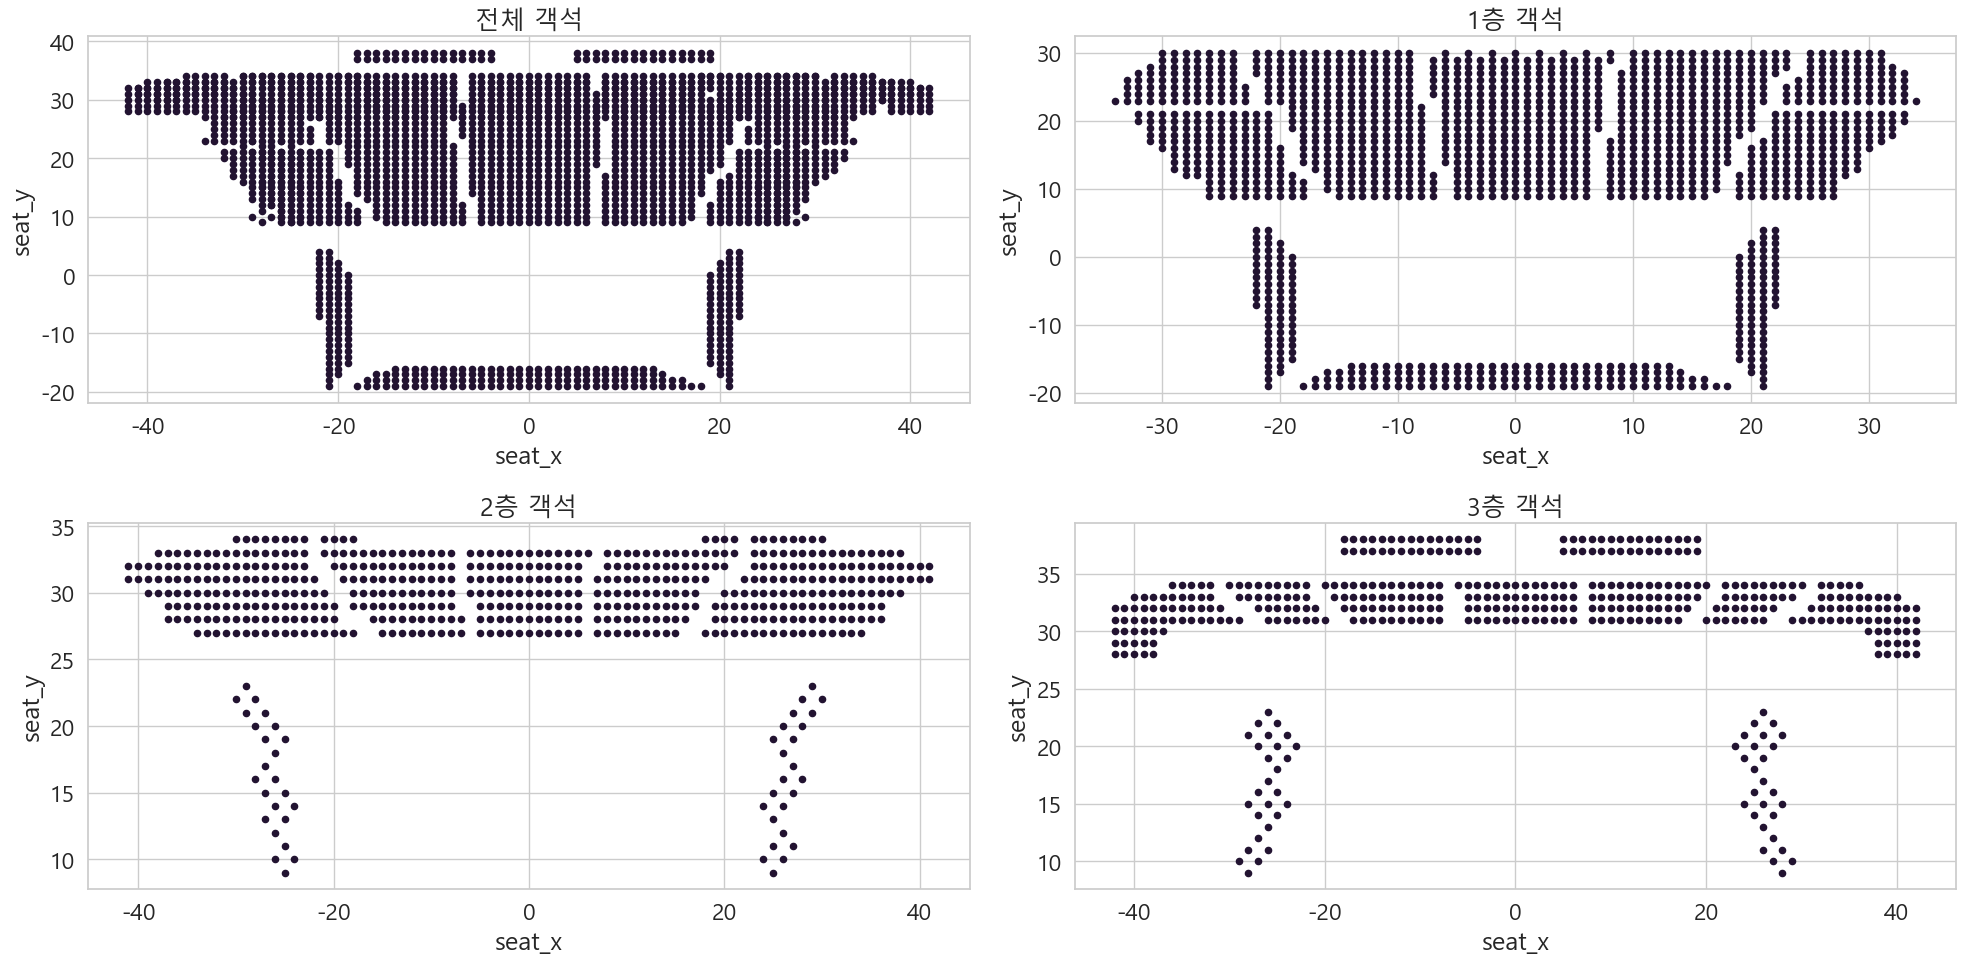

In [29]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
seat_xyz.plot.scatter(x='seat_x', y='seat_y', title='전체 객석', ax=plt.gca())

plt.subplot(2,2,2)
seat_xyz[(seat_xyz['seat_floor']=='1') | (seat_xyz['seat_floor']=='합창석')].plot.scatter(x='seat_x', y='seat_y', title='1층 객석', ax=plt.gca())

plt.subplot(2,2,3)
seat_xyz[seat_xyz['seat_floor']=='2'].plot.scatter(x='seat_x', y='seat_y', title='2층 객석', ax=plt.gca())

plt.subplot(2,2,4)
seat_xyz[seat_xyz['seat_floor']=='3'].plot.scatter(x='seat_x', y='seat_y', title='3층 객석', ax=plt.gca())

plt.tight_layout()
plt.show()

## Distance From Stage

In [30]:
def distance_from_point(bm_x=0, bm_y=0, bm_z=0, seat_xyz=None):
    if seat_xyz is None:
        raise ValueError("seat_xyz must be provided")
        
    return np.sqrt((bm_x - seat_xyz['seat_x'])**2 + (bm_y - seat_xyz['seat_y'])**2 + (bm_z - seat_xyz['floor_z'])**2)

In [31]:
seat_xyz['from_stage'] = distance_from_point(seat_xyz=seat_xyz); seat_xyz

,seat,seat_x,seat_y,floor_z,seat_floor,seat_block,from_stage
0,1층 A블록 1열 1,27,9,0,1,A,28.460499
1,1층 A블록 1열 2,26,9,0,1,A,27.513633
2,1층 A블록 1열 3,25,9,0,1,A,26.570661
3,1층 A블록 1열 4,24,9,0,1,A,25.632011
4,1층 A블록 1열 5,23,9,0,1,A,24.698178
...,...,...,...,...,...,...,...
2500,합창석 H블록 4열 8,22,0,10,합창석,H,-24.166092
2501,합창석 H블록 4열 9,22,1,10,합창석,H,-24.186773
2502,합창석 H블록 4열 10,22,2,10,합창석,H,-24.248711
2503,합창석 H블록 4열 11,22,3,10,합창석,H,-24.351591


## Distance From Sound Point

In [32]:
sound_info_dict = {'1st_left':[34,31,15], '1st_right':[-34,31,15], '2nd':[0,33,10], '3rd_left':[9,33,10], '3rd_right':[-9,33,10],
                   '4rd_left':[27,34,10], '4rd_right':[-27,34,10], '5rd_left':[25,30,0], '5rd_rignt':[-25,30,0],
                   '6rd_left':[12,9,0], '6rd_right':[-12,9,0], '7rd':[0,30,0], '8rd_left':[13,19,0], '8rd_right':[-13,19,0]}

In [33]:
for key, values in sound_info_dict.items():
    seat_xyz[f'from_{key}'] = distance_from_point(bm_x=values[0], bm_y=values[1], bm_z=values[2], seat_xyz=seat_xyz)

In [34]:
def calculate_weighted_acoustic_value(acoustic_weights, seat_xyz, alpha=1e-3):
    
    acoustic_value_per_seat = pd.Series(0, index=seat_xyz.index, dtype=float)
    
    for i, column_name in enumerate(seat_xyz.columns[7:]):
        acoustic_value_per_seat += acoustic_weights[i] / (seat_xyz[column_name] + alpha)
    
    return acoustic_value_per_seat

In [35]:
acoustic_weights = np.array([0.2, 0.2, 0.31, 0.375, 0.375, 1.1, 1.1, 1.2, 1.2, 1.64, 1.64, 1.7, 4.76, 4.76])


seat_xyz['acoustic_value'] = calculate_weighted_acoustic_value(acoustic_weights, seat_xyz)

In [36]:
columns_to_remove = seat_xyz.iloc[:,7:21].columns
seat_xyz = seat_xyz.loc[:, ~seat_xyz.columns.isin(columns_to_remove)];seat_xyz

,seat,seat_x,seat_y,floor_z,seat_floor,seat_block,from_stage,acoustic_value
0,1층 A블록 1열 1,27,9,0,1,A,28.460499,0.769375
1,1층 A블록 1열 2,26,9,0,1,A,27.513633,0.797085
2,1층 A블록 1열 3,25,9,0,1,A,26.570661,0.827012
3,1층 A블록 1열 4,24,9,0,1,A,25.632011,0.859478
4,1층 A블록 1열 5,23,9,0,1,A,24.698178,0.894878
...,...,...,...,...,...,...,...,...
2500,합창석 H블록 4열 8,22,0,10,합창석,H,-24.166092,0.652327
2501,합창석 H블록 4열 9,22,1,10,합창석,H,-24.186773,0.668523
2502,합창석 H블록 4열 10,22,2,10,합창석,H,-24.248711,0.685122
2503,합창석 H블록 4열 11,22,3,10,합창석,H,-24.351591,0.702068


## Distance From Exit

In [37]:
exit_seat_xyz = seat_xyz[['seat','seat_floor','seat_block','seat_x','seat_y','floor_z']]
floor_df = exit_seat_xyz[~exit_seat_xyz['seat_block'].isin([str(i) for i in range(1, 13)])]
box1_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['1'])]
box2_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['2'])]
box3_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['3'])]
box4_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['4'])]
box5_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['5'])]
box6_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['6'])]
box7_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['7'])]
box8_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['8'])]
box9_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['9'])]
box10_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['10'])]
box11_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['11'])]
box12_df = exit_seat_xyz[exit_seat_xyz['seat_block'].isin(['12'])]

In [38]:
floor_exit_dict = {
    'chorus_eixt_1':[23,-20,10], 'chorus_eixt_2':[23,-8,10], 'chorus_eixt_3':[23,5,10], 'chorus_eixt_4':[-23,-20,10], 'chorus_eixt_5':[-23,-8,10], 'chorus_eixt_6':[-23,5,10], 
    'floor1_eixt_1':[33,13,0], 'floor1_eixt_2':[36,18,0], 'floor1_eixt_3':[38,23,0], 'floor1_eixt_4':[25,34,0], 'floor1_eixt_5':[10,34,0],
    'floor1_eixt_6':[-10,34,0], 'floor1_eixt_7':[-24,34,0], 'floor1_eixt_8':[-33,13,0], 'floor1_eixt_9':[-36,18,0], 'floor1_eixt_10':[-38,23,0],
    'floor2_eixt_1':[26,36,10], 'floor2_eixt_2':[9,34,10], 'floor2_eixt_3':[-9,34,10], 'floor2_eixt_4':[-26,36,10],
    'floor3_eixt_1':[28,37,15], 'floor3_eixt_2':[-28,37,15]
}

In [39]:
box_exit_dict = {
    'box1_eixt':[28,13,10,box1_df], 'box2_eixt':[29,18,10,box2_df], 'box3_eixt':[31,24,10,box3_df], 'box4_eixt':[-31,24,10,box4_df],
    'box5_eixt':[-29,18,10,box5_df], 'box6_eixt':[-28,13,10,box6_df], 'box7_eixt':[31,14,15,box7_df], 'box8_eixt':[30,19,15,box8_df],
    'box9_eixt':[30,25,15,box9_df], 'box10_eixt':[-30,25,15,box10_df], 'box11_eixt':[-30,19,15,box11_df], 'box12_eixt':[-31,14,15,box12_df]
}

In [40]:
for key, values in floor_exit_dict.items():
    floor_df[f'from_{key}'] = distance_from_point(bm_x=values[0], bm_y=values[1], bm_z=values[2], seat_xyz=floor_df, chorus_plus=True)

for key, values in box_exit_dict.items():
    values[3]['from_exit'] = distance_from_point(bm_x=values[0], bm_y=values[1], bm_z=values[2], seat_xyz=values[3])

In [41]:
floor_df['from_exit'] = floor_df.apply(lambda row : min(row['from_chorus_eixt_1'], row['from_chorus_eixt_2'], row['from_chorus_eixt_3'], 
                                                         row['from_chorus_eixt_4'], row['from_chorus_eixt_5'], row['from_chorus_eixt_6'],
                                                         row['from_floor1_eixt_1'], row['from_floor1_eixt_2'], row['from_floor1_eixt_3'], 
                                                         row['from_floor1_eixt_4'], row['from_floor1_eixt_5'], row['from_floor1_eixt_6'], row['from_floor1_eixt_7'], 
                                                         row['from_floor1_eixt_8'], row['from_floor1_eixt_9'], row['from_floor1_eixt_10'],
                                                         row['from_floor2_eixt_1'], row['from_floor2_eixt_2'], row['from_floor2_eixt_3'], row['from_floor2_eixt_4'], 
                                                         row['from_floor3_eixt_1'], row['from_floor3_eixt_2']), axis=1)
floor_df = floor_df[['seat','seat_floor','seat_block','seat_x','seat_y','floor_z','from_exit']]

box_df = pd.concat([box1_df, box2_df, box3_df, box4_df, box5_df, box6_df, box7_df, box8_df, box9_df, box10_df, box11_df, box12_df])

In [42]:
exit_distance = pd.concat([floor_df,box_df])[['seat','from_exit']]
seat_xyz = seat_xyz.merge(exit_distance, on='seat', how='left')[['seat','seat_x','seat_y','floor_z','from_stage','acoustic_value','from_exit']]; seat_xyz

,seat,seat_x,seat_y,floor_z,from_stage,acoustic_value,from_exit
0,1층 A블록 1열 1,27,9,0,28.460499,0.769375,7.211103
1,1층 A블록 1열 2,26,9,0,27.513633,0.797085,8.062258
2,1층 A블록 1열 3,25,9,0,26.570661,0.827012,8.944272
3,1층 A블록 1열 4,24,9,0,25.632011,0.859478,9.848858
4,1층 A블록 1열 5,23,9,0,24.698178,0.894878,10.770330
...,...,...,...,...,...,...,...
2500,합창석 H블록 4열 8,22,0,10,-24.166092,0.652327,5.099020
2501,합창석 H블록 4열 9,22,1,10,-24.186773,0.668523,4.123106
2502,합창석 H블록 4열 10,22,2,10,-24.248711,0.685122,3.162278
2503,합창석 H블록 4열 11,22,3,10,-24.351591,0.702068,2.236068


### Cosine Similarity

In [43]:
def colculate_cosine_similarity(seat_xyz):
    unit_vector = [0,1,0]
    
    vectors = seat_xyz[['seat_x', 'seat_y', 'floor_z']].values
    
    cosine_similarities = [np.dot(vector, unit_vector) / (np.linalg.norm(vector) * np.linalg.norm(unit_vector)) for vector in vectors]
    
    return cosine_similarities

In [44]:
seat_xyz['cosine_sim'] = colculate_cosine_similarity(seat_xyz)
seat_xyz

,seat,seat_x,seat_y,floor_z,from_stage,acoustic_value,from_exit,cosine_sim
0,1층 A블록 1열 1,27,9,0,28.460499,0.769375,7.211103,0.316228
1,1층 A블록 1열 2,26,9,0,27.513633,0.797085,8.062258,0.327111
2,1층 A블록 1열 3,25,9,0,26.570661,0.827012,8.944272,0.338719
3,1층 A블록 1열 4,24,9,0,25.632011,0.859478,9.848858,0.351123
4,1층 A블록 1열 5,23,9,0,24.698178,0.894878,10.770330,0.364399
...,...,...,...,...,...,...,...,...
2500,합창석 H블록 4열 8,22,0,10,-24.166092,0.652327,5.099020,0.000000
2501,합창석 H블록 4열 9,22,1,10,-24.186773,0.668523,4.123106,0.041345
2502,합창석 H블록 4열 10,22,2,10,-24.248711,0.685122,3.162278,0.082479
2503,합창석 H블록 4열 11,22,3,10,-24.351591,0.702068,2.236068,0.123195


### 객석 Feature 병합

In [45]:
df_concert = df_concert.merge(seat_xyz, on=['seat','floor_z'], how='left'); df_concert.head()

,unique_perform_code,seat,age,gender,tran_date,tran_time,play_date,play_st_time,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,reservation_yn,play_holiday,play_weekday,play_year,play_month,tran_diff_pre_open,seat_floor,seat_block,seat_row,seat_num,paid_member,paid_membership_cnt,paid_membership_price,floor_z,converted_block,seat_x,seat_y,from_stage,acoustic_value,from_exit,cosine_sim
0,0,1층 A블록 10열 10,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,10,0,0,0.0,0,A,23,18,29.206164,1.081916,11.180340,0.616308
1,0,1층 A블록 10열 11,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,11,0,0,0.0,0,A,22,18,28.425341,1.147151,12.083046,0.633238
2,0,1층 A블록 10열 7,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,7,0,0,0.0,0,A,26,18,31.622777,0.934230,8.602325,0.569210
3,0,1층 A블록 10열 8,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,8,0,0,0.0,0,A,25,18,30.805844,0.977498,9.433981,0.584305
4,0,1층 A블록 10열 9,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,9,0,0,0.0,0,A,24,18,30.000000,1.026166,10.295630,0.600000


# 공연진행석 일괄 삭제

In [46]:
concert_official = ['1층 A블록 15열 9', '1층 A블록 15열 10', '1층 A블록 15열 11', '1층 A블록 15열 12',
                    '1층 B블록 15열 12', '1층 B블록 15열 13',
                    '1층 C블록 13열 1', '1층 C블록 13열 2', '1층 C블록 13열 3', '1층 C블록 13열 4', '1층 C블록 13열 5', '1층 C블록 13열 6',
                    '2층 C블록 7열 1', '2층 C블록 7열 2', '2층 C블록 7열 12', '2층 C블록 7열 13']

In [47]:
df_concert = df_concert[~df_concert['seat'].isin(concert_official)];df_concert

,unique_perform_code,seat,age,gender,tran_date,tran_time,play_date,play_st_time,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,reservation_yn,play_holiday,play_weekday,play_year,play_month,tran_diff_pre_open,seat_floor,seat_block,seat_row,seat_num,paid_member,paid_membership_cnt,paid_membership_price,floor_z,converted_block,seat_x,seat_y,from_stage,acoustic_value,from_exit,cosine_sim
0,0,1층 A블록 10열 10,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,10,0,0,0.0,0,A,23,18,29.206164,1.081916,11.180340,0.616308
1,0,1층 A블록 10열 11,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,11,0,0,0.0,0,A,22,18,28.425341,1.147151,12.083046,0.633238
2,0,1층 A블록 10열 7,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,7,0,0,0.0,0,A,26,18,31.622777,0.934230,8.602325,0.569210
3,0,1층 A블록 10열 8,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,8,0,0,0.0,0,A,25,18,30.805844,0.977498,9.433981,0.584305
4,0,1층 A블록 10열 9,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,9,0,0,0.0,0,A,24,18,30.000000,1.026166,10.295630,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882646,737,합창석 H블록 4열 1,30.0,M,2023-05-01,1841,2023-06-07,1930,81000,2,골드회원 할인10%,2938,2023-02-05,2023-02-06,독주,콘서트홀,85,20,1,0,0,2,2023,6,85,합창석,H,4,1,1,1,10.0,10,H,22,-7,-25.159491,0.552330,1.414214,-0.278225
882647,737,합창석 H블록 4열 10,50.0,F,2023-05-19,1307,2023-06-07,1930,90000,0,일반,2938,2023-02-05,2023-02-06,독주,콘서트홀,85,20,0,1,0,2,2023,6,103,합창석,H,4,10,1,2,14.0,10,H,22,2,-24.248711,0.685122,3.162278,0.082479
882648,737,합창석 H블록 4열 11,40.0,F,2023-05-29,1317,2023-06-07,1930,81000,0,골드회원 할인10%,2938,2023-02-05,2023-02-06,독주,콘서트홀,85,20,1,1,0,2,2023,6,113,합창석,H,4,11,1,1,10.0,10,H,22,3,-24.351591,0.702068,2.236068,0.123195
882649,737,합창석 H블록 4열 12,70.0,F,2023-03-30,1306,2023-06-07,1930,85000,2,그린회원 할인5%,2938,2023-02-05,2023-02-06,독주,콘서트홀,85,20,1,0,0,2,2023,6,53,합창석,H,4,12,1,1,2.0,10,H,22,4,-24.494897,0.719294,1.414214,0.163299


## Genre Feature

In [48]:
def genre_split(df, genre):
    if isinstance(genre, str):
        return df[df['genre']==genre]
    else:
        return df[(df['genre']==genre[0])|(df['genre']==genre[1])]

In [49]:
df_classic = genre_split(df_concert, ['교향곡','클래식'])
df_semisolo = genre_split(df_concert, ['독주','실내악'])
df_choir= genre_split(df_concert, '합창')
df_vocal = genre_split(df_concert, '성악')

df_genre_lst = [df_classic, df_semisolo, df_choir, df_vocal]

# [코로나 기간 보정]
## 좌석 count 변수 보정
**▶ 기간 : 2020.03.22 ~ 2022.01.01**
- 코로나 기간 동안 실행된 거리두기 정책으로 인해 한 칸 내지 두 칸 띄어앉기 기간 有
- 그러나 클러스터링에 활용되는 좌석 예매 횟수는 상대적인 수치이므로, **별도의 코로나 기간 보정 없이 제외하는 것**이 낫다고 판단.
- 코로나 기간의 예매 내역은 **좌석 예매 횟수 count에 반영하지 않도록** 처리 (예매 내역 자체는 보존)

In [50]:
# 장르별 DataFrame Feature 생성
for df in df_genre_lst:
    # 좌석별 train_diff_pre_open의 median값
    df['seat_tran_diff_median'] = df.groupby('seat')['tran_diff_pre_open'].transform('median')
    
    # 정상 기간 데이터는 1, 코로나 기간은 0으로 설정한 뒤 정상 기간의 좌석별 예매 횟수
    df['normal_period'] = ((df['play_date'] <= '2020-03-22') | (df['play_date'] >= '2022-01-01')).astype(int)
    df['seat_reserved_cnt'] = df.groupby('seat')['normal_period'].transform('sum')
    
    # 정상 기간의 회원/유료 회원의 예매 횟수
    filtered_df = df[df['normal_period'] == 1]  # 정상 기간의 데이터 필터링

    df['seat_member_cnt'] = df['seat'].map(filtered_df.groupby('seat')['member_yn'].sum())  # 정상 기간에서 좌석별 회원의 예매 횟수를 df에 mapping
    df['seat_paid_member_cnt'] = df['seat'].map(filtered_df.groupby('seat')['paid_member'].sum())  # 정상 기간에서 좌석별 유료 회원의 예매 횟수를 df에 mapping

    df['seat_member_cnt'] = df['seat_member_cnt'].fillna(0)  # 코로나 기간의 행에 대해서 0으로 대체
    df['seat_paid_member_cnt'] = df['seat_paid_member_cnt'].fillna(0)  # 코로나 기간의 행에 대해서 0으로 대체
    
    # 좌석별 선예매일로부터 실제 예매일까지의 차이 중앙값 
    df['seat_tran_diff_median'] = df.groupby('seat')['tran_diff_pre_open'].transform('median')
    
    # 좌석별 초대권 횟수
    seat_invite_counts  = df[df['discount_type'] == '초대권'].groupby('seat')['discount_type'].count()
    df['seat_invite_cnt'] = df['seat'].map(seat_invite_counts).fillna(0)
    
    # 좌석별 무료 / 유료 멤버십 회원의 예매 비율
    df['seat_member_rate'] = (df['seat_member_cnt'] /  df['seat_reserved_cnt'] *100).fillna(0)
    df['seat_paid_member_rate'] = (df['seat_paid_member_cnt'] / df['seat_reserved_cnt'] * 100).fillna(0)

In [51]:
df_classic.isna().sum()

unique_perform_code           0
seat                          0
age                      374508
gender                   374508
tran_date                     0
tran_time                     0
play_date                     0
play_st_time                  0
price                         0
ticket_cancel                 0
discount_type                 0
performance_code              0
pre_open_date                 0
open_date                     0
genre                         0
place                         0
running_time                  0
intermission                  0
member_yn                     0
reservation_yn                0
play_holiday                  0
play_weekday                  0
play_year                     0
play_month                    0
tran_diff_pre_open            0
seat_floor                    0
seat_block                    0
seat_row                      0
seat_num                      0
paid_member                   0
paid_membership_cnt           0
paid_mem

In [52]:
df_semisolo.isna().sum()

unique_perform_code          0
seat                         0
age                      25448
gender                   25448
tran_date                    0
tran_time                    0
play_date                    0
play_st_time                 0
price                        0
ticket_cancel                0
discount_type                0
performance_code             0
pre_open_date                0
open_date                    0
genre                        0
place                        0
running_time                 0
intermission                 0
member_yn                    0
reservation_yn               0
play_holiday                 0
play_weekday                 0
play_year                    0
play_month                   0
tran_diff_pre_open           0
seat_floor                   0
seat_block                   0
seat_row                     0
seat_num                     0
paid_member                  0
paid_membership_cnt          0
paid_membership_price        0
floor_z 

In [53]:
df_choir.isna().sum()

unique_perform_code          0
seat                         0
age                      86098
gender                   86098
tran_date                    0
tran_time                    0
play_date                    0
play_st_time                 0
price                        0
ticket_cancel                0
discount_type                0
performance_code             0
pre_open_date                0
open_date                    0
genre                        0
place                        0
running_time                 0
intermission                 0
member_yn                    0
reservation_yn               0
play_holiday                 0
play_weekday                 0
play_year                    0
play_month                   0
tran_diff_pre_open           0
seat_floor                   0
seat_block                   0
seat_row                     0
seat_num                     0
paid_member                  0
paid_membership_cnt          0
paid_membership_price        0
floor_z 

In [54]:
df_vocal.isna().sum()

unique_perform_code          0
seat                         0
age                      26201
gender                   26201
tran_date                    0
tran_time                    0
play_date                    0
play_st_time                 0
price                        0
ticket_cancel                0
discount_type                0
performance_code             0
pre_open_date                0
open_date                    0
genre                        0
place                        0
running_time                 0
intermission                 0
member_yn                    0
reservation_yn               0
play_holiday                 0
play_weekday                 0
play_year                    0
play_month                   0
tran_diff_pre_open           0
seat_floor                   0
seat_block                   0
seat_row                     0
seat_num                     0
paid_member                  0
paid_membership_cnt          0
paid_membership_price        0
floor_z 

In [55]:
df_concert = pd.concat([df_classic, df_semisolo, df_choir, df_vocal], axis=0); df_concert

,unique_perform_code,seat,age,gender,tran_date,tran_time,play_date,play_st_time,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,reservation_yn,play_holiday,play_weekday,play_year,play_month,tran_diff_pre_open,seat_floor,seat_block,seat_row,seat_num,paid_member,paid_membership_cnt,paid_membership_price,floor_z,converted_block,seat_x,seat_y,from_stage,acoustic_value,from_exit,cosine_sim,seat_tran_diff_median,normal_period,seat_reserved_cnt,seat_member_cnt,seat_paid_member_cnt,seat_invite_cnt,seat_member_rate,seat_paid_member_rate
0,0,1층 A블록 10열 10,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,10,0,0,0.0,0,A,23,18,29.206164,1.081916,11.180340,0.616308,19.0,1,265,73.0,53.0,155.0,27.547170,20.000000
1,0,1층 A블록 10열 11,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,11,0,0,0.0,0,A,22,18,28.425341,1.147151,12.083046,0.633238,20.5,1,267,91.0,68.0,124.0,34.082397,25.468165
2,0,1층 A블록 10열 7,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,7,0,0,0.0,0,A,26,18,31.622777,0.934230,8.602325,0.569210,24.0,1,221,42.0,32.0,143.0,19.004525,14.479638
3,0,1층 A블록 10열 8,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,8,0,0,0.0,0,A,25,18,30.805844,0.977498,9.433981,0.584305,23.0,1,245,41.0,32.0,166.0,16.734694,13.061224
4,0,1층 A블록 10열 9,NaN,None,2023-04-22,1222,2023-04-26,1930,0,0,초대권,1,2023-03-20,2023-03-20,클래식,콘서트홀,100,15,0,1,0,2,2023,4,33,1,A,10,9,0,0,0.0,0,A,24,18,30.000000,1.026166,10.295630,0.600000,21.0,1,247,51.0,36.0,141.0,20.647773,14.574899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879293,733,합창석 G블록 3열 10,NaN,None,2019-01-13,1949,2019-01-17,2000,10000,0,차액,2920,2018-11-19,2018-11-19,성악,콘서트홀,120,20,0,1,0,3,2019,1,55,합창석,G,3,10,0,0,0.0,10,G,-8,-18,-22.090722,0.477330,15.132746,-0.814822,30.0,1,3,1.0,1.0,0.0,33.333333,33.333333
879294,733,합창석 G블록 3열 2,NaN,None,2019-01-13,1951,2019-01-17,2000,6000,0,차액,2920,2018-11-19,2018-11-19,성악,콘서트홀,120,20,0,1,0,3,2019,1,55,합창석,G,3,2,0,0,0.0,10,G,-16,-18,-26.076810,0.459250,7.280110,-0.690268,30.0,1,2,0.0,0.0,0.0,0.000000,0.000000
879295,733,합창석 G블록 3열 3,NaN,None,2019-01-13,1955,2019-01-17,2000,20000,0,차액,2920,2018-11-19,2018-11-19,성악,콘서트홀,120,20,0,1,0,3,2019,1,55,합창석,G,3,3,0,0,0.0,10,G,-15,-18,-25.475478,0.462121,8.246211,-0.706562,29.5,1,2,0.0,0.0,0.0,0.000000,0.000000
879296,733,합창석 G블록 3열 4,NaN,None,2019-01-13,1957,2019-01-17,2000,30000,0,차액,2920,2018-11-19,2018-11-19,성악,콘서트홀,120,20,0,1,0,3,2019,1,55,합창석,G,3,4,0,0,0.0,10,G,-14,-18,-24.899799,0.464827,9.219544,-0.722897,29.5,1,2,0.0,0.0,0.0,0.000000,0.000000


# 데이터 내보내기

In [56]:
# Concert Hall Data
df_concert.to_csv("data/df_concert_hall.csv", index=False)

# Concert Hall - 교향곡, 클래식 Data
df_classic.to_csv("data/df_classic.csv", index=False)

# Concert Hall - 독주, 실내악 Data
df_semisolo.to_csv("data/df_semisolo.csv", index=False)

# Concert Hall - 합창 Data
df_choir.to_csv("data/df_choir.csv", index=False)

# Concert Hall - 성악 Data
df_vocal.to_csv("data/df_vocal.csv", index=False)